# Imports

In [1]:
import csv
import json
import random
import re
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns

import torch

from datasets import (
    Dataset,
    DatasetDict,
    concatenate_datasets,
    load_dataset,
    load_from_disk,
)
from transformers import (
    AutoModelForTokenClassification,
    AutoTokenizer,
    DataCollatorForTokenClassification,
    Trainer,
    TrainingArguments,
    set_seed,
)

import evaluate

from nameparser import HumanName
from names_dataset import NameDataset, NameWrapper
from ethnicseer import EthnicClassifier
import nltk
from nltk.corpus import wordnet as wn

import pycountry_convert as pc
import pycountry
import pickle

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, cohen_kappa_score


# ------------------------------------------------------------------------------

from transformers import BertTokenizerFast, BertForTokenClassification
from datasets import ClassLabel
from evaluate import load as load_metric

In [2]:
model_name = "bert-base-cased"

# Load GPU

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# Tokenisation & Alignment

In [4]:
ontonotes_id_to_label = {
    0: "O", 1: "B-CARDINAL", 2: "B-DATE", 3: "I-DATE", 4: "B-PERSON", 5: "I-PERSON",
    6: "B-NORP", 7: "B-GPE", 8: "I-GPE", 9: "B-LAW", 10: "I-LAW", 11: "B-ORG", 12: "I-ORG",
    13: "B-PERCENT", 14: "I-PERCENT", 15: "B-ORDINAL", 16: "B-MONEY", 17: "I-MONEY",
    18: "B-WORK_OF_ART", 19: "I-WORK_OF_ART", 20: "B-FAC", 21: "B-TIME", 22: "I-CARDINAL",
    23: "B-LOC", 24: "B-QUANTITY", 25: "I-QUANTITY", 26: "I-NORP", 27: "I-LOC",
    28: "B-PRODUCT", 29: "I-TIME", 30: "B-EVENT", 31: "I-EVENT", 32: "I-FAC",
    33: "B-LANGUAGE", 34: "I-PRODUCT", 35: "I-ORDINAL", 36: "I-LANGUAGE"
}

conll_label_to_id = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3,
                     'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}
id2label = {v: k for k, v in conll_label_to_id.items()}

ontonotes_to_conll_entity = {
    "PERSON": "PER", "ORG": "ORG", "GPE": "LOC", "LOC": "LOC",
    "NORP": "MISC", "FAC": "MISC", "EVENT": "MISC", "WORK_OF_ART": "MISC",
    "LAW": "MISC", "PRODUCT": "MISC", "LANGUAGE": "MISC",
    "DATE": None, "TIME": None, "PERCENT": None, "MONEY": None,
    "QUANTITY": None, "ORDINAL": None, "CARDINAL": None
}

In [6]:
def process_data(data_list):

    def process_single(data):
        word_ids = data['word_ids']
        predictions = data['predictions']
        gold = data['gold']
        tokenized_tokens = data['tokens']

        word_ids = [a for a in word_ids if a is not None]

        processed_predictions = []
        processed_gold = []

        current_word_id = None
        current_predictions = []
        current_gold = []

        for idx, word_id in enumerate(word_ids):
            if word_id != current_word_id:
                if current_predictions:
                    processed_predictions.append(
                        Counter(current_predictions).most_common(1)[0][0])
                    processed_gold.append(
                        Counter(current_gold).most_common(1)[0][0])

                current_word_id = word_id
                current_predictions = [predictions[idx]]
                current_gold = [gold[idx]]
            else:
                current_predictions.append(predictions[idx])
                current_gold.append(gold[idx])

        if current_predictions:
            processed_predictions.append(
                Counter(current_predictions).most_common(1)[0][0])
            processed_gold.append(
                Counter(current_gold).most_common(1)[0][0])

        return processed_predictions, processed_gold

    processed_predictions_list = []
    processed_gold_list = []

    for data in data_list:
        processed_predictions, processed_gold = process_single(data)
        processed_predictions_list.append(processed_predictions)
        processed_gold_list.append(processed_gold)

    return processed_predictions_list, processed_gold_list


def evaluate_predictions(p, test_data):
    predictions, labels, _ = p

    pred_indices = [np.argmax(p, axis=-1) for p in predictions]
    label_indices = labels

    pred_tags = [[id2label[p] for p, l in zip(p_seq, l_seq) if l != -100]
                 for p_seq, l_seq in zip(pred_indices, label_indices)]
    gold_tags = [[id2label[l] for l in l_seq if l != -100]
                 for l_seq in label_indices]

    def add_preds(example, idx):
        length = len(example['word_ids'])
        example['predictions'] = pred_tags[idx][:length]
        example['gold'] = gold_tags[idx][:length]
        return example

    test_data = test_data.map(add_preds, with_indices=True)

    length = len(test_data['predictions'][0])

    pred, gold = process_data(test_data)

    flat_pred = [label for seq in pred for label in seq]
    flat_gold = [label for seq in gold for label in seq]

    print(classification_report(flat_gold, flat_pred, zero_division=0))

    return (flat_pred, flat_gold)

# Model

## ConLL Trained mode

In [7]:
conll_main = load_from_disk("./splits/conll_main")
conll_clean = load_from_disk("./splits/conll_clean")

ontonotes_main = load_from_disk("./splits/ontonotes_main")
ontonotes_clean = load_from_disk("./splits/ontonotes_clean")

In [7]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

label_list = ['O', 'B-PER', 'I-PER', 'B-ORG',
              'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']


def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding=True,
        return_special_tokens_mask=True,
        return_offsets_mapping=True,
    )
    all_word_ids = []
    all_labels = []
    for i, labels in enumerate(examples["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        all_word_ids.append(word_ids)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            else:
                label_ids.append(labels[word_idx])
            previous_word_idx = word_idx
        all_labels.append(label_ids)

    tokenized_inputs["labels"] = all_labels
    tokenized_inputs["word_ids"] = all_word_ids
    return tokenized_inputs

In [8]:
conll_main = conll_main.map(tokenize_and_align_labels, batched=True)
ontonotes_main = ontonotes_main.map(tokenize_and_align_labels, batched=True)

### investigating data

conll2003


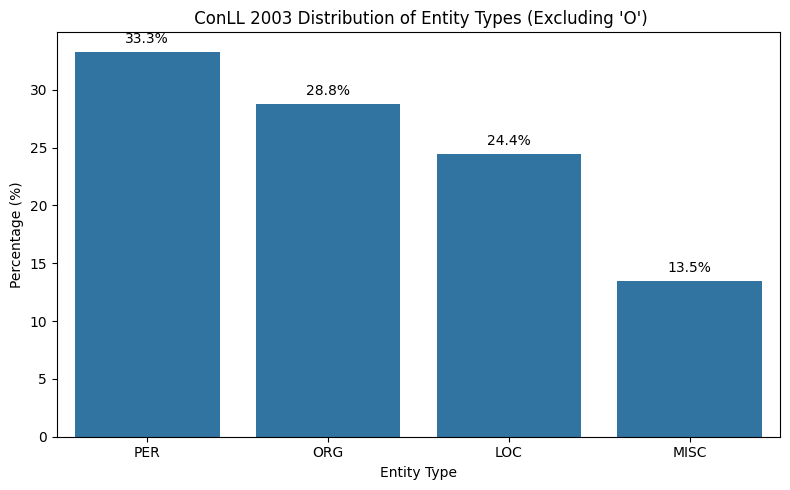

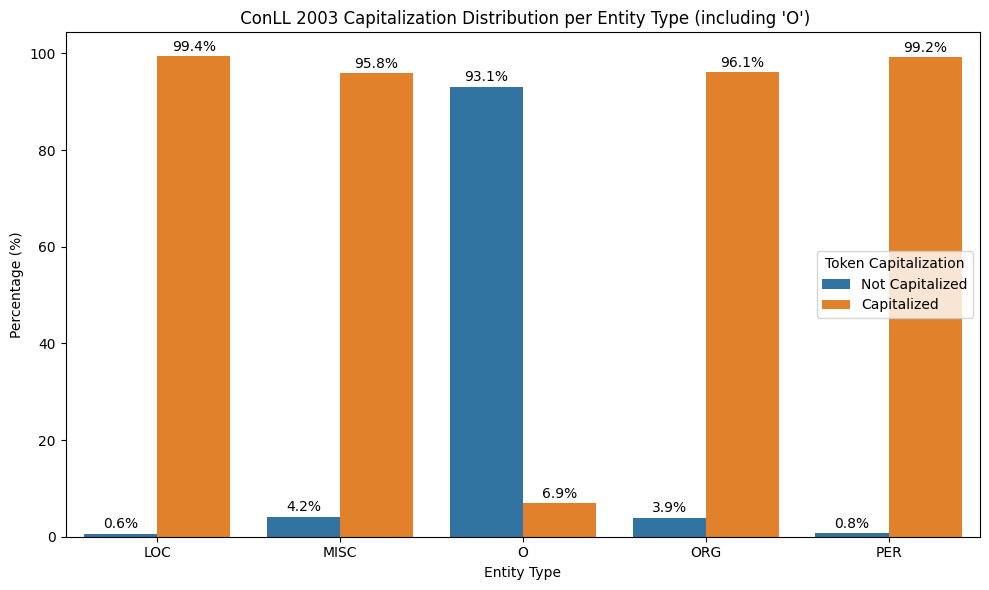

parquet


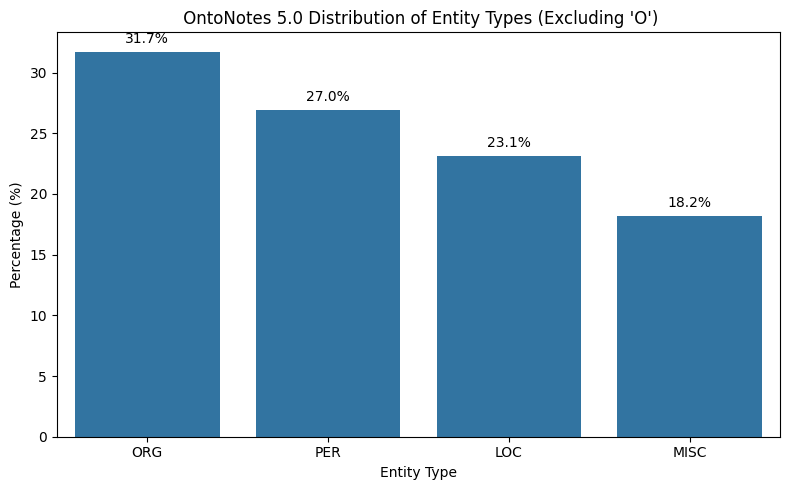

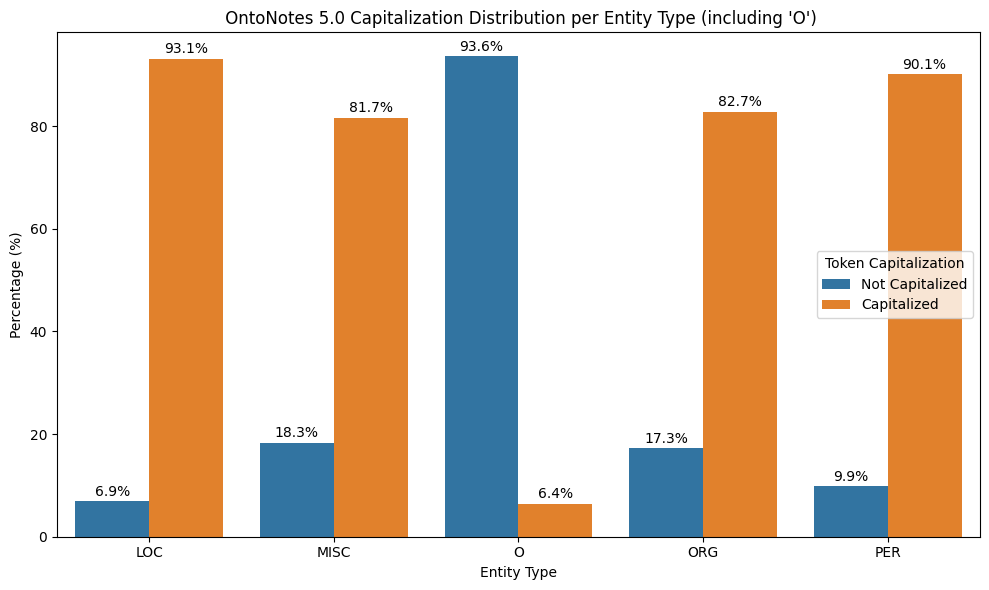

In [9]:
def build_entity_db(dataset, id2label):
    rows = []
    for i in range(len(dataset)):
        tokens = dataset[i]['tokens']
        label_ids = dataset[i]['labels']
        labels = [id2label[l] for l in label_ids]
        for token, label in zip(tokens, labels):
            entity_type = label.split("-")[-1] if label != "O" else "O"
            rows.append({
                "sentence_id": i,
                "token": token,
                "label": label,
                "entity_type": entity_type
            })
    return pd.DataFrame(rows)


for i in [conll_main, ontonotes_main]:

    print(i.builder_name)

    name = ''
    if i.builder_name == 'conll2003':
        name = 'ConLL 2003'
    else:
        name = 'OntoNotes 5.0'
    entity_df = build_entity_db(i, id2label)

    # Filter out "O" and group by entity_type
    entity_only = entity_df[entity_df["entity_type"] != "O"]

    # Count and calculate percentages
    type_counts = entity_only["entity_type"].value_counts().reset_index()
    type_counts.columns = ["entity_type", "count"]
    type_counts["percentage"] = 100 * \
        type_counts["count"] / type_counts["count"].sum()

    # Plot
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(data=type_counts, x="entity_type", y="percentage")

    # Add percentage labels on top of bars
    for bar, perc in zip(ax.patches, type_counts["percentage"]):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.5,
            f'{perc:.1f}%',
            ha='center',
            va='bottom'
        )

    # Aesthetics
    plt.ylabel("Percentage (%)")
    plt.xlabel("Entity Type")
    plt.title(f" {name} Distribution of Entity Types (Excluding 'O')")
    plt.tight_layout()
    plt.show()

    # Add capitalization info: True if first character is uppercase
    entity_df["is_capitalized"] = entity_df["token"].str[0].str.isupper()

    # Group by entity type and capitalization, count tokens
    cap_counts = (
        entity_df
        .groupby(["entity_type", "is_capitalized"])
        .size()
        .reset_index(name="count")
    )

    # Calculate percentages within each entity type
    cap_counts["percentage"] = (
        cap_counts.groupby("entity_type")["count"]
        .transform(lambda x: 100 * x / x.sum())
    )

    # Map boolean to readable label
    cap_counts["capitalization"] = cap_counts["is_capitalized"].map(
        {True: "Capitalized", False: "Not Capitalized"})

    # Plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=cap_counts,
        x="entity_type",
        y="percentage",
        hue="capitalization"
    )

    # Add labels on top of bars
    for bar in ax.patches:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.5,
                f"{height:.1f}%",
                ha="center",
                va="bottom"
            )

    # Aesthetics
    plt.title(
        f" {name} Capitalization Distribution per Entity Type (including 'O')")
    plt.ylabel("Percentage (%)")
    plt.xlabel("Entity Type")
    plt.legend(title="Token Capitalization")
    plt.tight_layout()
    plt.show()

In [67]:
import gender_guesser.detector as gender

detector = gender.Detector()

conll2003


E:\Software\Anaconda\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 1.0.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
E:\Software\Anaconda\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.0.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


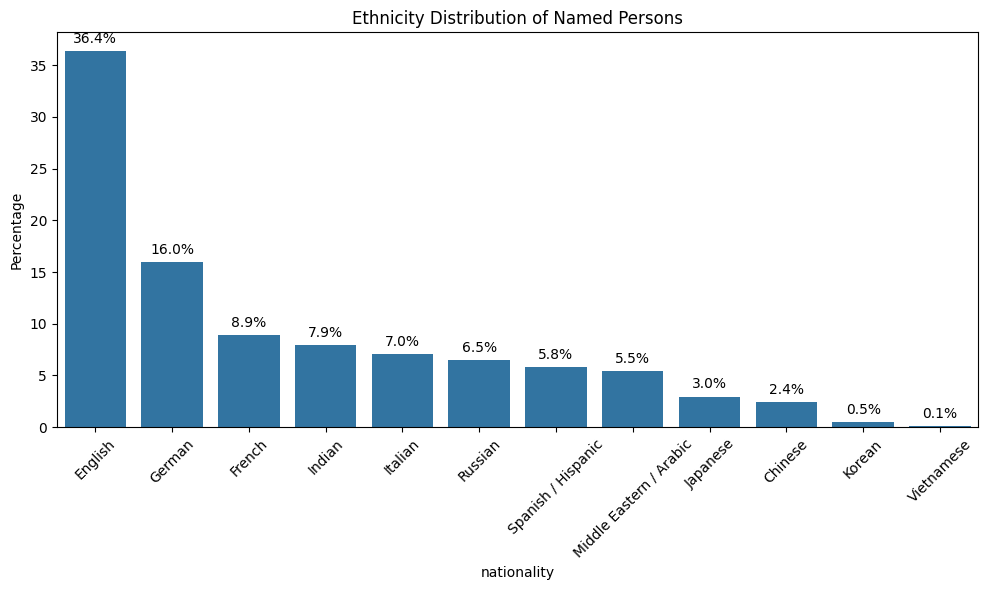

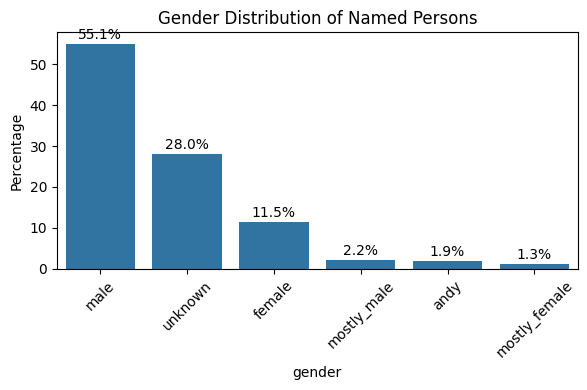

parquet


E:\Software\Anaconda\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 1.0.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
E:\Software\Anaconda\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.0.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


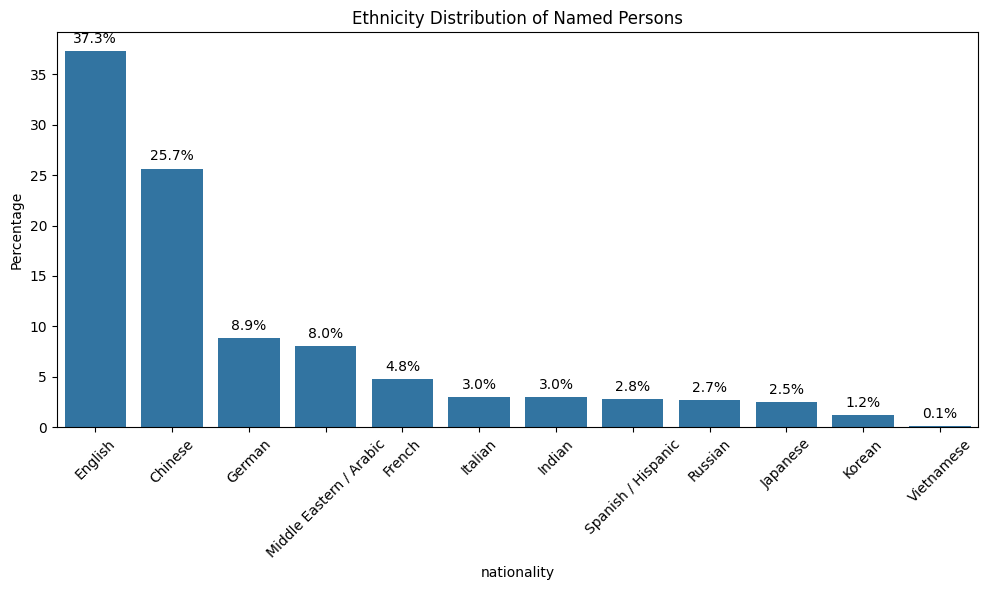

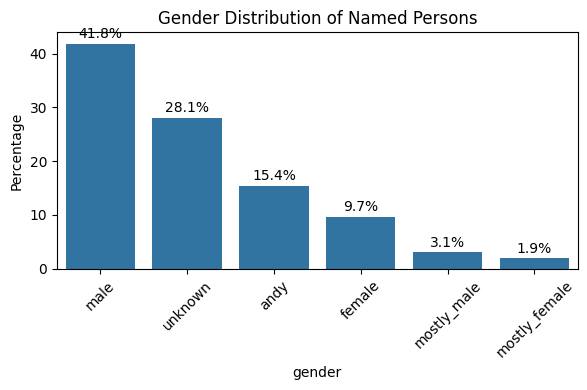

In [68]:
for i in [conll_main, ontonotes_main]:

    print(i.builder_name)
    entity_df = build_entity_db(i, id2label)

    # Step 1: Reconstruct full names using BIO labels
    names_by_sentence = defaultdict(list)
    current_name = []
    current_sentence = None

    for _, row in entity_df.iterrows():
        sent_id = row["sentence_id"]
        label = row["label"]
        token = row["token"]

        if label.startswith("B-PER"):
            if current_name:
                names_by_sentence[current_sentence].append(
                    " ".join(current_name))
            current_name = [token]
            current_sentence = sent_id
        elif label.startswith("I-PER") and current_name:
            current_name.append(token)
        else:
            if current_name:
                names_by_sentence[current_sentence].append(
                    " ".join(current_name))
                current_name = []

    # Catch leftover
    if current_name:
        names_by_sentence[current_sentence].append(" ".join(current_name))

    # Step 2: Flatten list of names and deduplicate
    full_names = [name for names in names_by_sentence.values()
                  for name in names]
    unique_names = list(set(full_names))

    ec = EthnicClassifier.load_pretrained_model()
    ethnicity_preds = ec.classify_names(unique_names)

    # Create a mapping from name to ethnicity
    name_to_ethnicity = dict(zip(unique_names, ethnicity_preds))
    entity_df["full_name"] = None

    current_name = []
    current_indices = []

    for idx, row in entity_df.iterrows():
        label = row["label"]
        token = row["token"]

        if label.startswith("B-PER"):
            # If we had a previous name, save it
            if current_name:
                full = " ".join(current_name)
                for i in current_indices:
                    entity_df.at[i, "full_name"] = full
            # Start a new name
            current_name = [token]
            current_indices = [idx]

        elif label.startswith("I-PER") and current_name:
            current_name.append(token)
            current_indices.append(idx)

        else:
            # End of a PER span
            if current_name:
                full = " ".join(current_name)
                for i in current_indices:
                    entity_df.at[i, "full_name"] = full
            current_name = []
            current_indices = []

    # Save last name if it was left unprocessed
    if current_name:
        full = " ".join(current_name)
        for i in current_indices:
            entity_df.at[i, "full_name"] = full

    # Add ethnicity column based on full_name
    entity_df["ethnicity"] = entity_df["full_name"].map(name_to_ethnicity)

    # Drop NaNs (i.e., keep only tokens that were part of PER entities)
    eth_dist = (
        entity_df.dropna(subset=["ethnicity"])
        ["ethnicity"]
        .value_counts(normalize=True) * 100
    ).reset_index()
    eth_dist.columns = ["ethnicity", "percentage"]
    # Mapping dictionary
    code_to_nationality = {
        "eng": "English",
        "chi": "Chinese",
        "ger": "German",
        "mea": "Middle Eastern / Arabic",
        "frn": "French",
        "ita": "Italian",
        "ind": "Indian",
        "spa": "Spanish / Hispanic",
        "rus": "Russian",
        "jap": "Japanese",
        "kor": "Korean",
        "vie": "Vietnamese"
    }

    # Apply to your DataFrame
    eth_dist["nationality"] = eth_dist["ethnicity"].map(code_to_nationality)

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=eth_dist, x="nationality", y="percentage")

    # Add labels on top of each bar
    for bar in ax.patches:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.5,
            f"{height:.1f}%",
            ha="center",
            va="bottom"
        )

    plt.title("Ethnicity Distribution of Named Persons")
    plt.ylabel("Percentage")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Extract first names only
    entity_df["first_name"] = entity_df["full_name"].str.split().str[0]

    # Apply gender detection
    entity_df["gender"] = entity_df["first_name"].apply(
        lambda x: detector.get_gender(x) if pd.notnull(x) else None)

    gender_dist = (
        entity_df.dropna(subset=["gender"])
        ["gender"]
        .value_counts(normalize=True) * 100
    ).reset_index()
    gender_dist.columns = ["gender", "percentage"]

    plt.figure(figsize=(6, 4))
    ax = sns.barplot(data=gender_dist, x="gender", y="percentage")

    for bar in ax.patches:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.5,
            f"{height:.1f}%",
            ha="center",
            va="bottom"
        )

    plt.title("Gender Distribution of Named Persons")
    plt.ylabel("Percentage")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Model stuff

In [9]:
mod = BertForTokenClassification.from_pretrained(
    "bert-base-cased", num_labels=len(label_list))

metric = load_metric("seqeval")


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    return metric.compute(predictions=true_predictions, references=true_labels)


data_collator = DataCollatorForTokenClassification(tokenizer)

training_args = TrainingArguments(
    output_dir="./results/conll-case",
    eval_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    report_to="none",
    fp16=True,
    save_strategy="no",
)

CBC_trainer = Trainer(
    model=mod,
    args=training_args,
    train_dataset=conll_main,
    eval_dataset=ontonotes_main,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\NIKHIL\AppData\Local\Temp\ipykernel_22636\4147057675.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  CBC_trainer = Trainer(


In [10]:
CBC_trainer.train()

Step,Training Loss


TrainOutput(global_step=3, training_loss=2.1497244834899902, metrics={'train_runtime': 12.408, 'train_samples_per_second': 2.418, 'train_steps_per_second': 0.242, 'total_flos': 1454575949100.0, 'train_loss': 2.1497244834899902, 'epoch': 3.0})

In [7]:
CBC_trainer.save_model("./saved_model/conll-cased")

In [10]:
model = AutoModelForTokenClassification.from_pretrained(
    "./saved_model/conll-cased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

id2label = {
    0: "O", 1: "B-PER", 2: "I-PER", 3: "B-ORG", 4: "I-ORG",
    5: "B-LOC", 6: "I-LOC", 7: "B-MISC", 8: "I-MISC"
}

metric = evaluate.load("seqeval")


def compute_metrics(p):
    predictions, labels = p
    predictions = predictions.argmax(axis=-1)

    true_predictions = []
    true_labels = []

    for pred_seq, label_seq in zip(predictions, labels):
        true_predictions.append(
            [id2label[p] for p, l in zip(pred_seq, label_seq) if l != -100])
        true_labels.append([id2label[l] for l in label_seq if l != -100])

    return metric.compute(predictions=true_predictions, references=true_labels)


conll_args = TrainingArguments(output_dir="./results/conll",
                               per_device_eval_batch_size=8, report_to="none")

CBC_trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics,
    args=conll_args,
)

C:\Users\NIKHIL\AppData\Local\Temp\ipykernel_14080\1038975773.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  CBC_trainer = Trainer(


In [11]:
cased_conll = CBC_trainer.predict(ontonotes_main)

E:\Software\Anaconda\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
pred, gold, q = cased_conll

pred_indices = [np.argmax(p, axis=-1) for p in pred]
pred_tags = [[id2label[p] for p, l in zip(p_seq, l_seq) if l != -100]
             for p_seq, l_seq in zip(pred_indices, gold)]
q

{'test_loss': 1.8883984088897705,
 'test_LOC': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1},
 'test_MISC': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 4},
 'test_ORG': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 0},
 'test_PER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 0},
 'test_overall_precision': 0.0,
 'test_overall_recall': 0.0,
 'test_overall_f1': 0.0,
 'test_overall_accuracy': 0.6305418719211823,
 'test_runtime': 0.9954,
 'test_samples_per_second': 10.046,
 'test_steps_per_second': 2.009}

In [10]:
with open('./results/cased_conll.pkl', 'wb') as f:
    pickle.dump(cased_conll, f)

In [11]:
with open('./results/cased_conll.pkl', 'rb') as f:
    cased_conll = pickle.load(f)

In [19]:
x, y = evaluate_predictions(cased_conll, ontonotes_main)

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

10 10 95 8
10 10 95 8
10 10 95 8
10 10 95 8
10 10 95 8
10 10 95 8
10 10 95 8
10 10 95 8
10 10 95 8
10 10 95 8
              precision    recall  f1-score   support

       B-LOC       0.00      0.00      0.00         1
      B-MISC       0.00      0.00      0.00         3
       I-LOC       0.00      0.00      0.00         0
      I-MISC       0.00      0.00      0.00         2
       I-ORG       0.00      0.00      0.00         0
       I-PER       0.00      0.00      0.00         0
           O       0.96      0.15      0.27       175

    accuracy                           0.15       181
   macro avg       0.14      0.02      0.04       181
weighted avg       0.93      0.15      0.26       181



## OntoNotes Trained Mode

In [22]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

label_list = ['O', 'B-PER', 'I-PER', 'B-ORG',
              'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']


mod = BertForTokenClassification.from_pretrained(
    "bert-base-cased", num_labels=len(label_list))

metric = load_metric("seqeval")


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    return metric.compute(predictions=true_predictions, references=true_labels)


data_collator = DataCollatorForTokenClassification(tokenizer)

training_args = TrainingArguments(
    output_dir="./results/onto-case",
    eval_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    report_to="none",
    fp16=True,
    save_strategy="no",)

OBC_trainer = Trainer(
    model=mod,
    args=training_args,
    train_dataset=ontonotes_main,
    eval_dataset=conll_main,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

OBC_trainer.train()

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\NIKHIL\AppData\Local\Temp\ipykernel_8112\4136997834.py:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  OBC_trainer = Trainer(


Step,Training Loss


TrainOutput(global_step=3, training_loss=2.125772476196289, metrics={'train_runtime': 21.607, 'train_samples_per_second': 1.388, 'train_steps_per_second': 0.139, 'total_flos': 1454575949100.0, 'train_loss': 2.125772476196289, 'epoch': 3.0})

In [23]:
OBC_trainer.save_model("./saved_model/onto-cased")

In [26]:
model = AutoModelForTokenClassification.from_pretrained(
    "./saved_model/onto-cased")
tokenizer = AutoTokenizer.from_pretrained(model_name)

id2label = {
    0: "O", 1: "B-PER", 2: "I-PER", 3: "B-ORG", 4: "I-ORG",
    5: "B-LOC", 6: "I-LOC", 7: "B-MISC", 8: "I-MISC"
}

metric = evaluate.load("seqeval")


def compute_metrics(p):
    predictions, labels = p
    predictions = predictions.argmax(axis=-1)

    true_predictions = []
    true_labels = []

    for pred_seq, label_seq in zip(predictions, labels):
        true_predictions.append(
            [id2label[p] for p, l in zip(pred_seq, label_seq) if l != -100])
        true_labels.append([id2label[l] for l in label_seq if l != -100])

    return metric.compute(predictions=true_predictions, references=true_labels)


onto_args = TrainingArguments(output_dir="./results/onto",
                              per_device_eval_batch_size=8, report_to="none")

OBC_trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics,
    args=onto_args,
)

C:\Users\NIKHIL\AppData\Local\Temp\ipykernel_8112\4175723938.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  OBC_trainer = Trainer(


In [32]:
cased_onto = OBC_trainer.predict(conll_main)

In [33]:
with open('./results/cased_onto.pkl', 'wb') as f:
    pickle.dump(cased_onto, f)

In [34]:
with open('./results/cased_onto.pkl', 'rb') as f:
    cased_onto = pickle.load(f)

In [35]:
x, y = evaluate_predictions(cased_onto, conll_main)

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

10 10 95 11
10 10 95 11
10 10 95 11
10 10 95 11
10 10 95 11
10 10 95 11
10 10 95 11
10 10 95 11
10 10 95 11
10 10 95 11
              precision    recall  f1-score   support

       B-LOC       0.13      0.22      0.17         9
      B-MISC       0.02      0.25      0.04         4
       B-ORG       0.00      0.00      0.00         8
       B-PER       0.00      0.00      0.00         7
       I-LOC       0.00      0.00      0.00         1
      I-MISC       0.00      0.00      0.00         4
       I-ORG       0.00      0.00      0.00         7
       I-PER       0.00      0.00      0.00         5
           O       0.72      0.19      0.30       122

    accuracy                           0.16       167
   macro avg       0.10      0.07      0.06       167
weighted avg       0.53      0.16      0.23       167



# Challenge dataset

## Stanford

In [53]:
df = pd.read_excel(
    "./Guided-Adversarial-Augmentation-main/Guided-Adversarial-Augmentation-main/data/data/conll2003/challenge_set.xlsx", header=None)

In [54]:
examples = []

i = 0
while i < len(df):
    row = df.iloc[i]
    if str(row[0]).startswith("GUID"):

        guid = str(df.iloc[i][1]).strip()

        try:
            quality = int(str(df.iloc[i+1][1]).strip())
        except (ValueError, TypeError):
            quality = 999

        try:
            aug_type = int(str(df.iloc[i+2][1]).strip())
        except (ValueError, TypeError):
            aug_type = 999

        tokens_row = df.iloc[i+3].dropna().tolist()[1:]
        labels_row = df.iloc[i+4].dropna().tolist()[1:]
        labels_row = [label.strip()
                      for label in labels_row if label.strip() != ""]

        if len(tokens_row) == len(labels_row):
            examples.append({
                "guid": guid,
                "quality": quality,
                "aug_type": aug_type,
                "tokens": tokens_row,
                "labels": labels_row
            })

        i += 6
    else:
        i += 1

challenge_dataset = Dataset.from_list(examples)

In [55]:
conll_label_to_id = {
    'O': 0,
    'B-PER': 1, 'I-PER': 2,
    'B-ORG': 3, 'I-ORG': 4,
    'B-LOC': 5, 'I-LOC': 6,
    'B-MISC': 7, 'I-MISC': 8,
}


def encode_labels(example):
    example["labels"] = [conll_label_to_id.get(
        label, 0) for label in example["labels"]]
    return example

In [56]:
challenge_dataset = challenge_dataset.map(encode_labels)

Map:   0%|          | 0/1418 [00:00<?, ? examples/s]

In [57]:
stanford_encoded = challenge_dataset.map(
    tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/1418 [00:00<?, ? examples/s]

In [59]:
stanford_encoded.save_to_disk("./splits/stanford_challenge_encoded_cased")

Saving the dataset (0/1 shards):   0%|          | 0/1418 [00:00<?, ? examples/s]

In [60]:
stanford_encoded = load_from_disk("./splits/stanford_challenge_encoded_cased")

In [61]:
# conll_results = CBC_trainer.evaluate(stanford_encoded)
# print(conll_results)

In [62]:
conll_results = CBC_trainer.predict(stanford_encoded)

In [63]:
with open('./results/conll_stanford_cased.pkl', 'wb') as f:
    pickle.dump(conll_results, f)

In [64]:
with open('./results/conll_stanford_cased.pkl', 'rb') as f:
    conll_stanford = pickle.load(f)

In [65]:
x, y = evaluate_predictions(conll_stanford, stanford_encoded)

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

10 10 158 11
10 10 158 11
10 10 158 11
10 10 158 11
10 10 158 11
10 10 158 11
10 10 158 11
10 10 158 11
10 10 158 11
10 10 158 11
              precision    recall  f1-score   support

       B-LOC       0.00      0.00      0.00         3
      B-MISC       0.02      0.12      0.03         8
       B-ORG       0.00      0.00      0.00        12
       B-PER       0.00      0.00      0.00         2
       I-LOC       0.00      0.00      0.00         2
      I-MISC       0.00      0.00      0.00         3
       I-ORG       0.27      0.30      0.29        23
       I-PER       0.20      0.50      0.29         2
           O       0.72      0.23      0.35       162

    accuracy                           0.22       217
   macro avg       0.13      0.13      0.11       217
weighted avg       0.57      0.22      0.30       217



In [68]:
predicted_label_ids = np.argmax(conll_stanford.predictions, axis=2)
true_label_ids = conll_stanford.label_ids

id_to_label = {v: k for k, v in conll_label_to_id.items()}

for i in range(len(true_label_ids)):
    tokens = stanford_encoded[i]['tokens']
    true_labels = []
    pred_labels = []

    for j, (true_id, pred_id) in enumerate(zip(true_label_ids[i], predicted_label_ids[i])):
        if true_id != -100:
            true_labels.append(id_to_label[true_id])
            pred_labels.append(id_to_label[pred_id])

    if true_labels != pred_labels:
        print(f"\n--- Sentence {i} ---")
        print("Tokens:       ", tokens)
        print("True Labels:  ", true_labels)
        print("Pred Labels:  ", pred_labels)


--- Sentence 0 ---
Tokens:        ['AL-AIN', 'Rugby', 'Union', ',', 'United', 'Arab', 'Emirates', '1996-12-06', '^']
True Labels:   ['B-ORG', 'B-ORG', 'B-ORG', 'B-ORG', 'I-ORG', 'I-ORG', 'O', 'B-LOC', 'I-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'O', 'O']
Pred Labels:   ['I-ORG', 'O', 'O', 'O', 'B-MISC', 'B-MISC', 'B-LOC', 'B-MISC', 'B-MISC', 'I-ORG', 'B-MISC', 'O', 'O', 'B-MISC', 'B-LOC', 'O']

--- Sentence 1 ---
Tokens:        ['The', 'Japan', 'City', 'Royals', 'began', 'the', 'defence', 'of', 'their', 'Asian', 'Cup', 'title', 'with', 'a', 'lucky', '2-1', 'win', 'against', 'Syria', 'in', 'a', 'Group', 'C', 'championship', 'match', 'on', 'Friday', '.', '^']
True Labels:   ['O', 'B-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'I-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Pred Labels:   ['I-ORG', 'I-LOC', 'I-ORG', 'I-ORG', 'B-MISC', 'B-LOC', 'B-MISC', 'O', 'I-LOC', 'I-LOC', 'B-LOC', 'I-ORG', 'B-MISC', 'O', 'B-MI

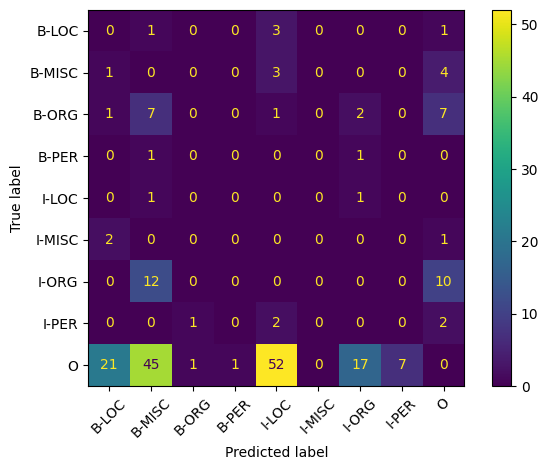

In [69]:
true_tags = []
pred_tags = []

for true_seq, pred_seq in zip(true_label_ids, predicted_label_ids):
    for t, p in zip(true_seq, pred_seq):
        if t != -100:
            true_tags.append(id_to_label[t])
            pred_tags.append(id_to_label[p])

unique_tags = sorted(set(true_tags + pred_tags))
cm = confusion_matrix(true_tags, pred_tags, labels=unique_tags)
for i in unique_tags:
    o_index = unique_tags.index(i)
    cm[o_index, o_index] = 0
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=unique_tags)
disp.plot()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Onto_results = ontoTrainer.evaluate(stanford_encoded)
# print(Onto_results)

In [71]:
onto_predictions_output = OBC_trainer.predict(
    stanford_encoded)

In [72]:
with open('./results/base_stanford_onto_casedf.pkl', 'wb') as f:
    pickle.dump(onto_predictions_output, f)

In [73]:
with open('./results/base_stanford_onto_casedf.pkl', 'rb') as f:
    base_stanford_onto = pickle.load(f)

In [74]:
x, y = evaluate_predictions(
    base_stanford_onto, stanford_encoded)

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

10 10 158 11
10 10 158 11
10 10 158 11
10 10 158 11
10 10 158 11
10 10 158 11
10 10 158 11
10 10 158 11
10 10 158 11
10 10 158 11
              precision    recall  f1-score   support

       B-LOC       0.00      0.00      0.00         3
      B-MISC       0.01      0.12      0.03         8
       B-ORG       0.00      0.00      0.00        12
       B-PER       0.00      0.00      0.00         2
       I-LOC       0.00      0.00      0.00         2
      I-MISC       0.00      0.00      0.00         3
       I-ORG       0.00      0.00      0.00        23
       I-PER       0.00      0.00      0.00         2
           O       0.77      0.27      0.40       162

    accuracy                           0.21       217
   macro avg       0.09      0.04      0.05       217
weighted avg       0.58      0.21      0.30       217



## Personal

In [77]:
def get_common_nouns():
    noun_set = set()
    for synset in wn.all_synsets('n'):
        for lemma in synset.lemmas():
            word = lemma.name().replace("_", " ")
            if word.islower() and word.isalpha():
                noun_set.add(word)
    return sorted(noun_set)


common_nouns = get_common_nouns()
print(f"Found {len(common_nouns)} common English nouns.")

In [ ]:
# # chosen_countries = ['MY', 'BD', 'IR', 'EG', 'MA', 'NG', 'ID', 'PH']
# # ['JP', 'CN', 'KR', 'VN']


# sentence_templates = [
#     "My name is {name}.",
#     "This is {name}, our new team member.",
#     "Have you met {name} from the accounting department?",
#     "Everyone was waiting for {name} to arrive.",
#     "Can you schedule a meeting with {name} next week?",
#     "Do you remember when {name} joined the company?",
#     "Isn't {name} presenting at the conference?",
#     "What did {name} say about the proposal yesterday?",
#     "{name}, the regional director, approved the budget.",
#     "The person you spoke to earlier, {name}, will send the report.",
#     "I met {name} and {name2} at the workshop in Jakarta.",
#     "{name} said that {name2} might be late due to traffic.",
#     "During yesterday's meeting, {name} brought up an interesting point.",
#     "After the interview, we offered {name} the position.",
#     "Although {name} was nervous, she performed well.",
#     "At the annual summit in Kuala Lumpur, {name} gave a keynote speech.",
#     "It was {name} who finalized the agreement.",
#     "The report, as mentioned by {name} (our new data analyst), needs a revision.",
#     "The final report was prepared by {name}.",
#     "Nobody expected {name} to handle the crisis so well.",
#     "The consultant who was hired by{name} recommended a new tool.",
#     "The woman seen talking to {name} was the CEO.",
#     "{name} and his colleague {name2} handled the presentation together.",
#     "Both {name} and {name2} have extensive experience in logistics.",
#     "{name} introduced {name2} as the lead consultant on the project.",
#     "{name}, the new project manager, presented the budget.",
#     "While the proposal was being finalized by the marketing team, {name}, who had just returned from Singapore, raised an objection.",
# ]

In [ ]:
nd = NameDataset()
country_codes = nd.get_country_codes()

continent_names = {
    'AF': 'Africa',
    'NA': 'North America',
    'OC': 'Oceania',
    'AN': 'Antarctica',
    'AS': 'Asia',
    'EU': 'Europe',
    'SA': 'South America',
}

continent_to_code = defaultdict(list)

continent_to_countries = defaultdict(list)

for code in country_codes:
    try:
        alpha_2 = code.alpha_2
        country = pycountry.countries.get(alpha_2=alpha_2)
        if not country:
            continue

        continent_code = pc.country_alpha2_to_continent_code(alpha_2)
        continent = continent_names[continent_code]

        continent_to_code[continent].append(alpha_2)
        continent_to_countries[continent].append((alpha_2, country.name))

    except Exception as e:
        print(f"Skipping {code} due to error: {e}")
        continue

In [ ]:
def get_names(country, n=10):
    names_dict = nd.get_top_names(n=n, country_alpha2=country)
    names = []
    if country in names_dict:
        country_names = names_dict[country]
        for gender in ['M', 'F']:
            if gender in country_names:
                names.extend(country_names[gender])
    return list(set(names))


def tokenize(text):
    tokens = re.findall(r"\w+|[^\w\s]", text, re.UNICODE)
    return tokens


def tag_tokens(tokens, person_names):
    tags = ["O"] * len(tokens)
    for name in person_names:
        name_tokens = name.split()
        n_len = len(name_tokens)
        for i in range(len(tokens) - n_len + 1):
            if tokens[i:i + n_len] == name_tokens:
                tags[i] = "B-PER"
                for j in range(i + 1, i + n_len):
                    tags[j] = "I-PER"
    return tags


def generate_challenge_dataset(num_samples=300):
    dataset = []

    for _ in range(num_samples):
        country = random.choice(chosen_countries)
        names = get_names(country, n=10)
        if not names:
            continue

        if len(names) == 1:
            name1 = names[0]
            name2 = None
        else:
            name1, name2 = random.sample(names, 2)

        template = random.choice(sentence_templates)

        if "{name2}" in template and name2 is None:
            sentence = template.format(name=name1, name2=name1)
            person_names = [name1]
        elif "{name2}" in template:
            sentence = template.format(name=name1, name2=name2)
            person_names = [name1, name2]
        else:
            sentence = template.format(name=name1)
            person_names = [name1]

        tokens = tokenize(sentence)
        tags = tag_tokens(tokens, person_names)

        dataset.append(list(zip(tokens, tags)))

    return dataset


def save_to_csv(dataset, filepath="non_western_ner_challenge.csv"):
    with open(filepath, mode="w", encoding="utf-8", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["sentence_id", "token", "tag"])
        for idx, sentence in enumerate(dataset):
            for token, tag in sentence:
                writer.writerow([idx, token, tag])

In [ ]:
for x in list(continent_to_code.keys()):
    print('Working on ', x)
    chosen_countries = continent_to_code[x]
    data = generate_challenge_dataset(num_samples=1000)
    save_to_csv(data, x+'_ner_challenge.csv')
    print(f"Saved {
          len(data)} sentences with non-Western names to {x}_ner_challenge.csv")

In [ ]:
name_data = []


def evaluate_csv(file):
    print('evaluating', file)
    scripted_challenge = pd.read_csv(file)

    examples = []
    for sentence_id, group in scripted_challenge.groupby("sentence_id"):
        tokens = group["token"].tolist()
        tags = group["tag"].tolist()
        examples.append({"tokens": tokens, "ner_tags": tags})

    unique_tags = sorted(set(tag for ex in examples for tag in ex["ner_tags"]))

    for ex in examples:
        ex["labels"] = [conll_label_to_id[tag] for tag in ex["ner_tags"]]

    challenge_dataset = Dataset.from_list(examples)
    tokenized = challenge_dataset.map(tokenize_and_align_labels, batched=True)
    a = CBC_trainer.predict(tokenized)

    with open(f'./results/challenge_{file[:-3]}.pkl', 'wb') as f:
        pickle.dump(a, f)

    x, y = evaluate_predictions(a, tokenized)
    print()
    print('-'*30)

    # a['eval_PER']['name'] = file
    # name_data.append(a['eval_PER'])
    # print(a['eval_PER'])
    # print()

In [ ]:
for x in list(continent_to_code.keys()):
    evaluate_csv(x+'_ner_challenge.csv')

In [ ]:
# def evaluate_csv_error(file):
#     print('evaluating', file)
#     scripted_challenge = pd.read_csv(file)

#     examples = []
#     for sentence_id, group in scripted_challenge.groupby("sentence_id"):
#         tokens = group["token"].tolist()
#         tags = group["tag"].tolist()
#         examples.append({"tokens": tokens, "ner_tags": tags})

#     for ex in examples:
#         ex["labels"] = [conll_label_to_id[tag] for tag in ex["ner_tags"]]

#     challenge_dataset = Dataset.from_list(examples)
#     tokenized = challenge_dataset.map(tokenize_and_align_labels, batched=True)

#     # Get model predictions
#     outputs = CBC_trainer.predict(tokenized)
#     predictions = outputs.predictions.argmax(-1)
#     true_labels = outputs.label_ids

#     # Error analysis
#     for i, example in enumerate(examples):
#         tokens = example['tokens']
#         expected_tags = example['ner_tags']
#         predicted_ids = predictions[i]
#         true_ids = true_labels[i]

#         predicted_tags = [id2label[id_] for id_, true_id in zip(
#             predicted_ids, true_ids) if true_id != -100]
#         expected_tags_clean = [id2label[true_id]
#                                for true_id in true_ids if true_id != -100]
#         tokens_clean = [t for t, true_id in zip(
#             tokens, true_ids) if true_id != -100]

#         for token, expected, predicted in zip(tokens_clean, expected_tags_clean, predicted_tags):
#             if expected != predicted:
#                 print(f"Word: {token}")
#                 print(f"Expected tag: {expected}")
#                 print(f"Predicted tag: {predicted}")
#                 print(f"Full sentence: {' '.join(tokens)}")
#                 print("------")

In [ ]:
# evaluate_csv_error('Oceania_ner_challenge.csv')

In [ ]:
# df = pd.DataFrame(name_data)

# # Extract region names
# df["region"] = df["name"].apply(lambda x: x.split("_ner_challenge")[0])

# # Plot settings
# metrics = ["precision", "recall", "f1"]
# colors = ["#66c2a5", "#fc8d62", "#8da0cb"]
# y_limits = {"precision": (0.95, 1.01), "recall": (
#     0.8, 1.05), "f1": (0.9, 1.01)}

# fig, axs = plt.subplots(3, 1, figsize=(10, 14))

# for i, met in enumerate(metrics):
#     sns.barplot(data=df, x="region", y=met, ax=axs[i], color=colors[i])
#     axs[i].set_title(met.capitalize())
#     axs[i].set_ylabel("Score")
#     axs[i].set_ylim(y_limits[met])
#     axs[i].set_xlabel("Region")
#     axs[i].tick_params(axis='x', rotation=45)

#     # Add values on top of bars
#     for p in axs[i].patches:
#         height = p.get_height()
#         axs[i].annotate(f'{height:.3f}',
#                         (p.get_x() + p.get_width() / 2, height),
#                         ha='center', va='bottom', fontsize=10)

# fig.suptitle("NER Challenge Metrics by Region", fontsize=16)
# plt.tight_layout(rect=[0, 0, 1, 0.95])

# plt.show()

In [ ]:
# scripted_challenge = pd.read_csv("non_western_ner_challenge.csv")

# examples = []
# for sentence_id, group in scripted_challenge.groupby("sentence_id"):
#     tokens = group["token"].tolist()
#     tags = group["tag"].tolist()
#     examples.append({"tokens": tokens, "ner_tags": tags})


# for ex in examples:
#     ex["labels"] = [conll_label_to_id[tag] for tag in ex["ner_tags"]]

In [ ]:
# challenge_dataset = Dataset.from_list(examples)
# tokenized = challenge_dataset.map(tokenize_and_align_labels, batched=True)
# predictions_output = CBC_trainer.predict(tokenized)

In [ ]:
# CBC_trainer.evaluate(tokenized)

In [ ]:
# pred_logits = predictions_output.predictions
# true_labels = predictions_output.label_ids

# pred_label_ids = np.argmax(pred_logits, axis=2)

# id2tag = {i: tag for tag, i in conll_label_to_id.items()}

# wrong_sentences = []
# for i in range(len(true_labels)):
#     gold = true_labels[i]
#     pred = pred_label_ids[i]

#     gold_filtered = [id2tag[lab] for lab, p in zip(gold, pred) if lab != -100]
#     pred_filtered = [id2tag[p] for lab, p in zip(gold, pred) if lab != -100]

#     gold_bper_positions = [idx for idx, tag in enumerate(
#         gold_filtered) if tag == 'B-PER']
#     pred_bper_positions = [idx for idx, tag in enumerate(
#         pred_filtered) if tag == 'B-PER']

#     # if gold_bper_positions != pred_bper_positions:
#     wrong_sentences.append({
#         "index": i,
#         "tokens": tokenized[i]["tokens"],
#         "gold_labels": gold_filtered,
#         "pred_labels": pred_filtered,
#     })

In [ ]:
# for idx, i in enumerate(wrong_sentences):
#     print(str(idx+1) + " " + " ".join(i['tokens']))
#     print(i['gold_labels'])
#     print(i['pred_labels'])
#     print()

# Seed Variability

In [ ]:

# tokenizer = AutoTokenizer.from_pretrained(model_name)

# conll_label_to_id = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3,
#                      'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}
# id2label = {v: k for k, v in conll_label_to_id.items()}

# conll_encoded = load_from_disk("./splits/conll_encoded")
# ontonotes_encoded = load_from_disk("./splits/ontonotes_encoded")

# data_collator = DataCollatorForTokenClassification(tokenizer)


# def compute_metrics(p):
#     predictions, labels = p
#     predictions = predictions.argmax(axis=-1)

#     true_predictions = []
#     true_labels = []

#     for pred_seq, label_seq in zip(predictions, labels):
#         true_predictions.append(
#             [id2label[p] for p, l in zip(pred_seq, label_seq) if l != -100])
#         true_labels.append([id2label[l] for l in label_seq if l != -100])

#     return metric.compute(predictions=true_predictions, references=true_labels)

In [42]:
seeds = [42, 106]
results = []

for seed in seeds:
    set_seed(seed)

    conll_model = AutoModelForTokenClassification.from_pretrained(
        model_name,
        num_labels=len(conll_label_to_id)
    )

    conll_args = TrainingArguments(
        output_dir=f"./results/conll_seed_{seed}",
        seed=seed,
        eval_strategy="no",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        gradient_accumulation_steps=2,
        num_train_epochs=3,
        weight_decay=0.01,
        load_best_model_at_end=True,
        report_to="none",
        fp16=True,
        logging_steps=1000,
        save_strategy="no",
    )

    CBC_trainer = Trainer(
        model=conll_model,
        args=conll_args,
        train_dataset=conll_main,
        eval_dataset=ontonotes_main,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    CBC_trainer.train()
    CBC_trainer.save_model("./saved_model/conll_seed_"+str(seed))

    pred = CBC_trainer.predict(ontonotes_main)

    print('pred len', len(pred))
    x, y = evaluate_predictions(pred, ontonotes_main)
    eval_result = {'predictions': x, 'seed': seed}
    results.append(eval_result)
    with open('./results/seed_var_results.pkl', 'wb') as f:
        pickle.dump(results, f)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\NIKHIL\AppData\Local\Temp\ipykernel_14080\3316735707.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  CBC_trainer = Trainer(


Step,Training Loss


E:\Software\Anaconda\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


pred len 3
              precision    recall  f1-score   support

       B-LOC       0.00      0.00      0.00         1
      B-MISC       0.00      0.00      0.00         3
       B-ORG       0.00      0.00      0.00         0
       B-PER       0.00      0.00      0.00         0
       I-LOC       0.00      0.00      0.00         0
      I-MISC       0.11      0.50      0.18         2
       I-ORG       0.00      0.00      0.00         0
       I-PER       0.00      0.00      0.00         0
           O       0.94      0.17      0.29       175

    accuracy                           0.17       181
   macro avg       0.12      0.07      0.05       181
weighted avg       0.91      0.17      0.28       181



Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\NIKHIL\AppData\Local\Temp\ipykernel_14080\3316735707.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  CBC_trainer = Trainer(


Step,Training Loss


E:\Software\Anaconda\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


pred len 3
              precision    recall  f1-score   support

       B-LOC       0.00      0.00      0.00         1
      B-MISC       0.00      0.00      0.00         3
       B-ORG       0.00      0.00      0.00         0
      I-MISC       0.00      0.00      0.00         2
       I-ORG       0.00      0.00      0.00         0
       I-PER       0.00      0.00      0.00         0
           O       1.00      0.35      0.52       175

    accuracy                           0.34       181
   macro avg       0.14      0.05      0.07       181
weighted avg       0.97      0.34      0.50       181



In [33]:
with open('./results/seed_var_results.pkl', 'rb') as f:
    seed_res = pickle.load(f)

In [43]:
from sklearn.metrics import cohen_kappa_score
from itertools import combinations

kappa_scores = []

for i, j in combinations(range(len(seed_res)), 2):
    preds_i = seed_res[i]['predictions']
    preds_j = seed_res[j]['predictions']

    kappa = cohen_kappa_score(preds_i, preds_j)
    kappa_scores.append(kappa)

    print(f"Cohen's kappa between seed {i} and seed {j}: {kappa:.6f}")

average_kappa = sum(kappa_scores) / len(kappa_scores)
print(f"\nAverage Cohen's kappa across all pairs: {average_kappa:.6f}")

Cohen's kappa between seed 0 and seed 1: 0.968157
Cohen's kappa between seed 0 and seed 2: 0.969363
Cohen's kappa between seed 0 and seed 3: 0.967762
Cohen's kappa between seed 0 and seed 4: 0.969770
Cohen's kappa between seed 1 and seed 2: 0.967929
Cohen's kappa between seed 1 and seed 3: 0.966223
Cohen's kappa between seed 1 and seed 4: 0.969460
Cohen's kappa between seed 2 and seed 3: 0.965784
Cohen's kappa between seed 2 and seed 4: 0.969494
Cohen's kappa between seed 3 and seed 4: 0.967538

Average Cohen's kappa across all pairs: 0.968148


In [44]:
import krippendorff

data = np.array([seed['predictions'] for seed in seed_res])

alpha = krippendorff.alpha(reliability_data=data,
                           level_of_measurement='nominal')

print(f"\nKrippendorff’s alpha (nominal): {alpha:.6f}")


Krippendorff’s alpha (nominal): 0.968148
